# Sentiment Analysis

#### Importing required libraries

In [1]:
# import libraties
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import naive_bayes
import xgboost as xgb
from sklearn.metrics import accuracy_score
import pickle

**Data Preprocessing**


Loading Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
#df = pd.read_csv("C:/Users/Admin/Downloads/datacapstone/sample30.csv")
reviews = pd.read_csv("/content/drive/MyDrive/sample30.csv")
print(reviews.shape)
reviews.head(3)

(30000, 15)


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive


### Analysing the Data

In [10]:
reviews.shape

(30000, 15)

**Observation: ** There are 15 columns as below


1. id
2. brand
3. categories
4. manufacturer
5. name
6. reviews_date
7. reviews_didPurchase
8. reviews_doRecommend
9. reviews_rating
10. reviews_text
11. reviews_title
12. reviews_userCity
13. reviews_userProvince
14. reviews_username
15. user_sentiment

In [11]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

### Handling Duplicates

In [12]:
sum(reviews.duplicated(subset=['id','reviews_username']))

2395

In [13]:
reviews=reviews.drop_duplicates(subset=['id','reviews_username'])


In [14]:
# Checking for Duplicate records
sum(reviews.duplicated())

0

**Observation:** All the records seems to be unique and there are no duplicates.

In [15]:
reviews.reviews_rating.value_counts()

5    19465
4     5480
3     1221
1     1063
2      376
Name: reviews_rating, dtype: int64

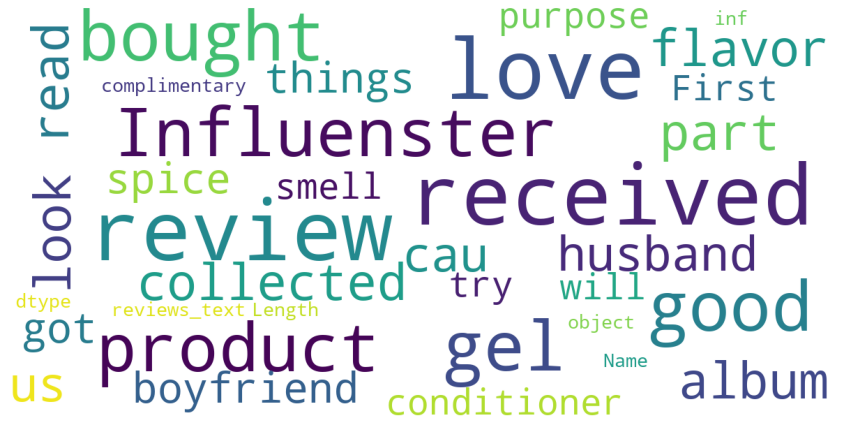

In [16]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(reviews['reviews_text'])


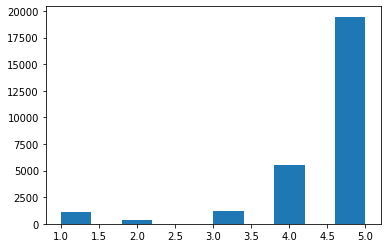

In [17]:
plt.hist(reviews['reviews_rating'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


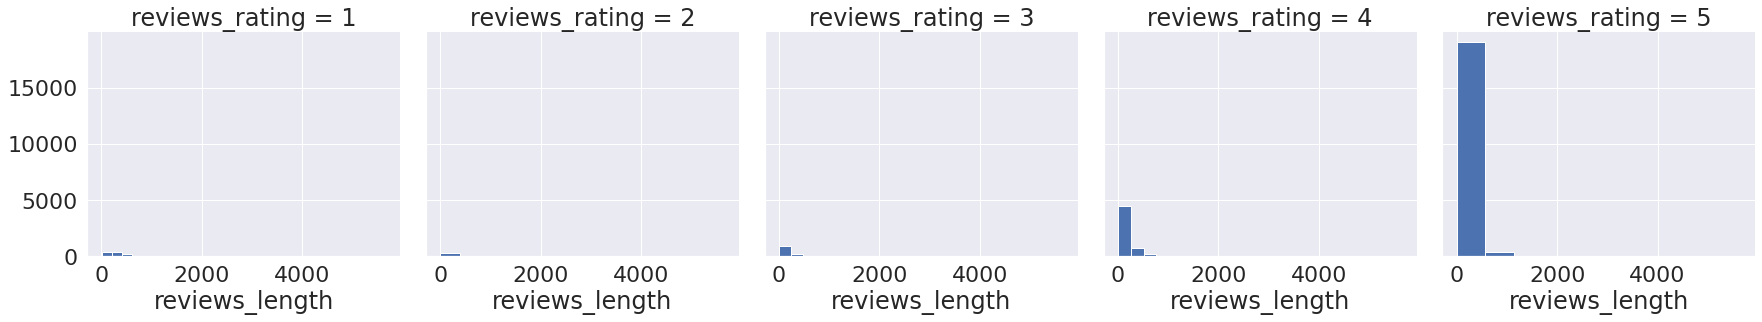

In [18]:
reviews['reviews_length']=reviews['reviews_text'].apply(len)
sns.set(font_scale=2.0)

g = sns.FacetGrid(reviews,col='reviews_rating',size=5)
g.map(plt.hist,'reviews_length')

In [19]:
reviews['reviews_didPurchase'].fillna("Review N/A",inplace=True)
reviews['reviews_didPurchase'].value_counts()

False         13575
Review N/A    12607
True           1423
Name: reviews_didPurchase, dtype: int64

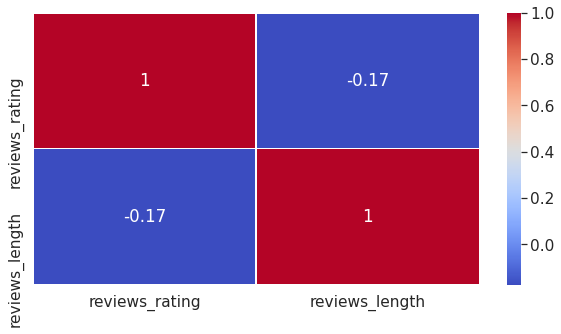

In [20]:
sns.set(font_scale=1.4)
plt.figure(figsize=(10, 5))
sns.heatmap(reviews.corr(), cmap='coolwarm', annot=True, linewidth=.5)

### Text Processing and Feature Extraction

In [21]:


all_text =reviews['reviews_text']
train_text= reviews['reviews_text']
y=reviews['reviews_rating']

word_vectorizer = TfidfVectorizer(sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(all_text)
train_word_feature = word_vectorizer.transform(train_text)

char_vectorizer=TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)
char_vectorizer.fit(all_text)
train_char_features= char_vectorizer.transform(train_text)

train_features =hstack([train_char_features, train_word_feature])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:520: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


In [22]:
pickle.dump(char_vectorizer, open('tranform.pkl', 'wb'))

In [23]:


X_train, X_test, y_train, y_test = train_test_split(train_features, y, test_size=0.3, random_state=10)

In [24]:

classifier_RF = RandomForestClassifier()
classifier_RF.fit(X_train, y_train)
pred_RF=classifier_RF.predict(X_test)

In [25]:

classifier_NB = naive_bayes.MultinomialNB()
classifier_NB.fit(X_train,y_train)
pred_NB = classifier_NB.predict(X_test)

In [26]:
classifier_xgb=xgb.XGBClassifier()
classifier_xgb.fit(X_train, y_train)
pred_xgb = classifier_xgb.predict(X_test)

In [27]:
NB_accuracy=accuracy_score(pred_NB, y_test)
xgb_accuracy=accuracy_score(pred_xgb, y_test)
rf_accuracy=accuracy_score(pred_RF,y_test)
print("Naive Bay Model accuracy", NB_accuracy)
print("Random Forest Model accuracy", rf_accuracy)
print("XGBoost Model accuracy", xgb_accuracy)

Naive Bay Model accuracy 0.7079207920792079
Random Forest Model accuracy 0.7324317797633422
XGBoost Model accuracy 0.7337599613619898


In [25]:

pickle.dump(classifier_RF, open('nlp_model.pkl', 'wb'))